In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [2]:
!pip install Lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00


In [3]:
!pip install plotly

In [4]:
import os
import datetime
import squarify
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
palette = 'Set2'

In [5]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',
                header = 0,
                 encoding = 'unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'], 
                 infer_datetime_format = True)

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

In [9]:
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Preprocessing

In [10]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df_copy = dataframe.copy()
    quartile1 = df_copy[variable].quantile(q1)
    quartile3 = df_copy[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_copy.loc[(df_copy[variable] < low_limit), variable] = low_limit
    df_copy.loc[(df_copy[variable] > up_limit), variable] = up_limit
    
    return df_copy

In [11]:
def ecommerce_preprocess(dataframe):
    df_copy = dataframe.copy()
    
    #Missing Values
    df_copy = df_copy.dropna()
    
    #Cancelled Orders & Quantity
    df_copy = df_copy[~df_copy['InvoiceNo'].str.contains('C', na = False)]
    df_copy = df_copy[df_copy['Quantity'] > 0]
    
    #Replacing Outliers
    df_copy = replace_with_thresholds(df_copy, "Quantity", q1 = 0.01, q3 = 0.99)
    df_copy = replace_with_thresholds(df_copy, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_copy["TotalPrice"] = df_copy["Quantity"] * df_copy["UnitPrice"]
    
    return df_copy

In [12]:
df = ecommerce_preprocess(df)

df[['Quantity','UnitPrice','TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,397924.000000,397924.000000,397924.000000
mean,11.833736,2.893163,20.627751
std,25.534512,3.227059,51.826400
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,298.500000,37.060000,3268.575000


## RFM Analysis

In [13]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [14]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()}).reset_index()

rfm.head()

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


In [15]:
rfm.columns = ['CustomerID','recency', 'frequency', 'monetary']
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


In [16]:
rfm = rfm[rfm['monetary'] > 0]

In [17]:
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


In [18]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_copy = dataframe.copy()
    df_copy["recency_score"] = pd.qcut(df_copy["recency"], 2, labels=[2, 1])
    df_copy["frequency_score"] = pd.qcut(
        df_copy["frequency"].rank(method="first"), 2, labels=[1, 2]
    )
    df_copy["monetary_score"] = pd.qcut(df_copy["monetary"], 2, labels=[1, 2])
    df_copy["RFM_SCORE"] = df_copy["recency_score"].astype(str) + df_copy["frequency_score"].astype(
        str
    ) + df_copy["monetary_score"].astype(str)

    return df_copy


rfm = get_rfm_scores(rfm)

In [19]:
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346,326,1,310.44,1,1,1,111
1,12347,3,7,4310.00,2,2,2,222
2,12348,76,4,1770.78,1,2,2,122
3,12349,19,1,1491.72,2,1,2,212
4,12350,311,1,331.46,1,1,1,111


In [20]:
seg_map = {r'111': 'hibernating',
           r'112': 'at_Risk',
           r'122': 'cant_loose',
           r'121': 'about_to_sleep',
           r'212': 'promising',
           r'211': 'new_customers',
           r'221': 'potential_loyalists',
           r'222': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,1,111,hibernating
1,12347,3,7,4310.00,2,2,2,222,champions
2,12348,76,4,1770.78,1,2,2,122,cant_loose
3,12349,19,1,1491.72,2,1,2,212,promising
4,12350,311,1,331.46,1,1,1,111,hibernating


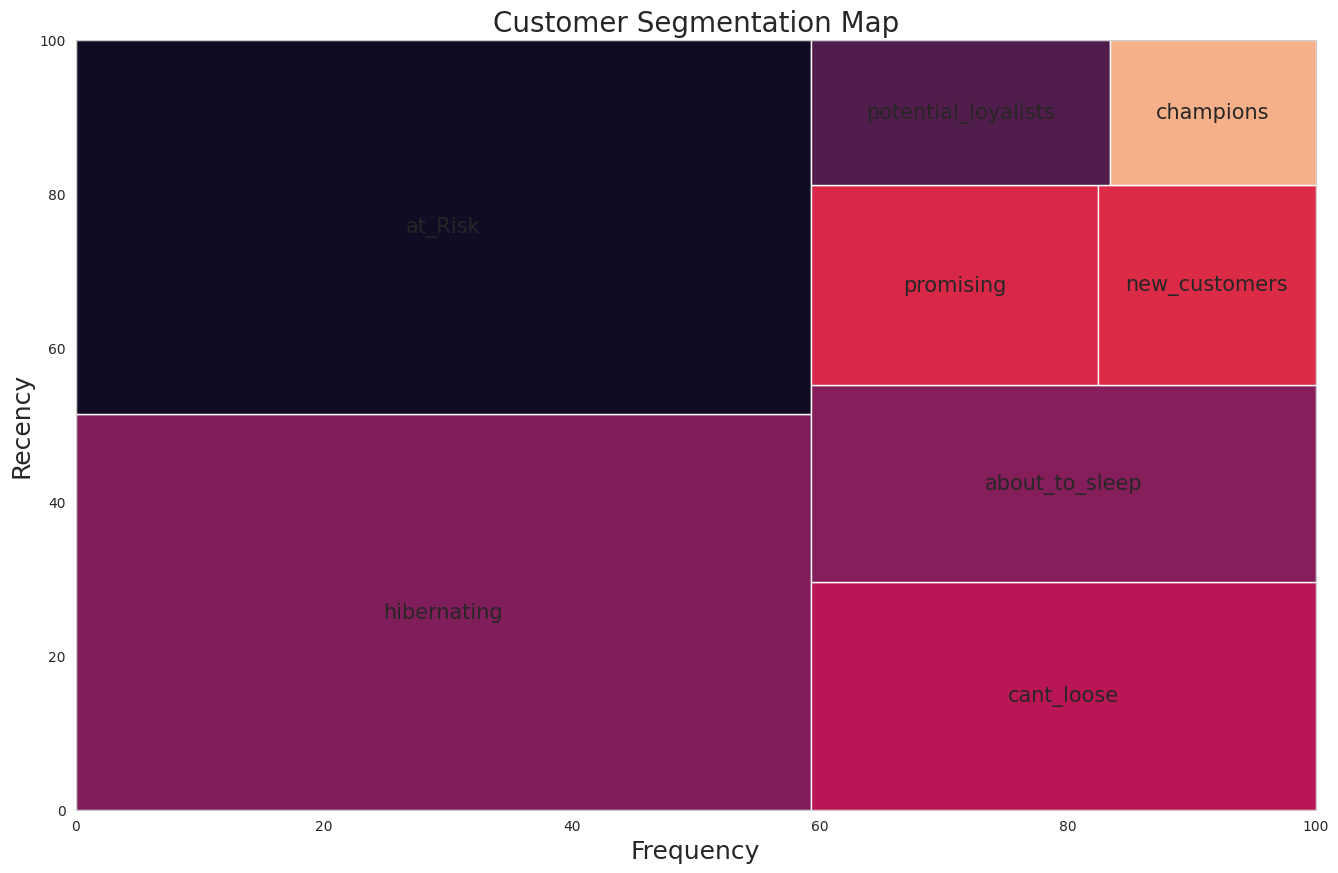

In [21]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

### Model Evaluation

In [22]:
X = rfm[['recency_score', 'frequency_score', 'monetary_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')

Number of Observations: 4338
Number of Segments: 8
Silhouette Score: 1.0
Calinski Harabasz Score: 1.0


## Segment Analysis

In [23]:
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

recency                          monetary  \
                           mean         std  max min         mean   
segment                                                             
about_to_sleep       147.409091   72.793633  359  52   411.175737   
at_Risk              146.023077   85.327393  372  52  1239.927446   
cant_loose           107.008850   58.159273  373  52  1892.876261   
champions             17.490537   13.152950   51   1  4683.896015   
hibernating          194.761182  100.574281  374  52   280.590328   
new_customers         25.752399   13.696509   51   1   311.498522   
potential_loyalists   22.601010   14.006793   51   1   452.924596   
promising             24.507353   14.623166   51   1  1163.290809   

                                                      frequency             \
                              std         max     min      mean        std   
segment                                                                      
about_to_sleep         154.276061     662.080   70.02  3.005051   0.898377   
at_Risk                911.397991    9182.345  663.61  1.569231   0.496139   
cant_loose            1488.586343   11578.875  663.65  4.696903   2.654317   
champions            13493.684923  266163.525  663.81  9.365632  12.296784   
hibernating            157.254263     662.590    3.75  1.186102   0.389345   
new_customers          162.262899     661.320    6.90  1.360845   0.480707   
potential_loyalists    151.640311     662.380   36.56  3.030303   0.928451   
promising              698.848891    6207.670  664.26  1.786765   0.411107   

                              
                     max min  
segment                       
about_to_sleep         6   2  
at_Risk                2   1  
cant_loose            34   2  
champions            210   2  
hibernating            2   1  
new_customers          2   1  
potential_loyalists    7   2  
promising              2   1

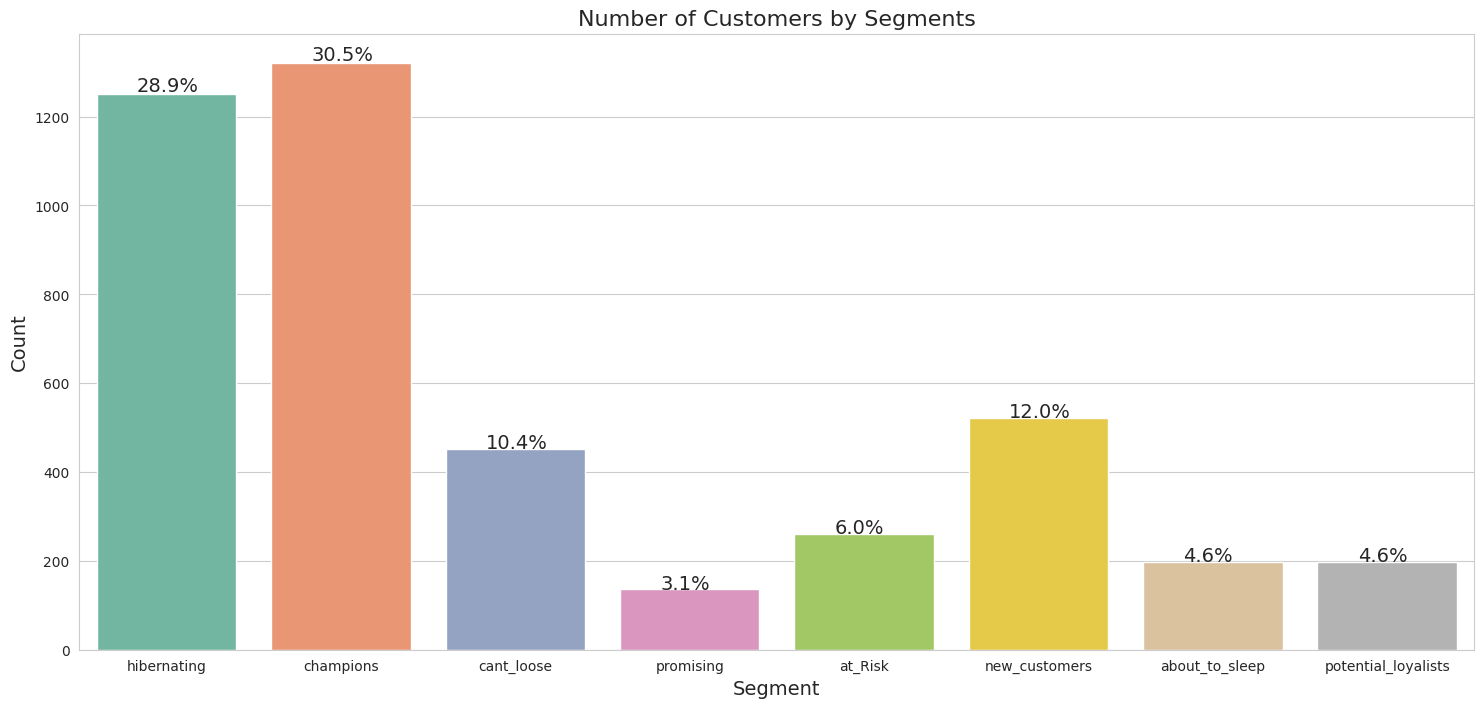

In [24]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

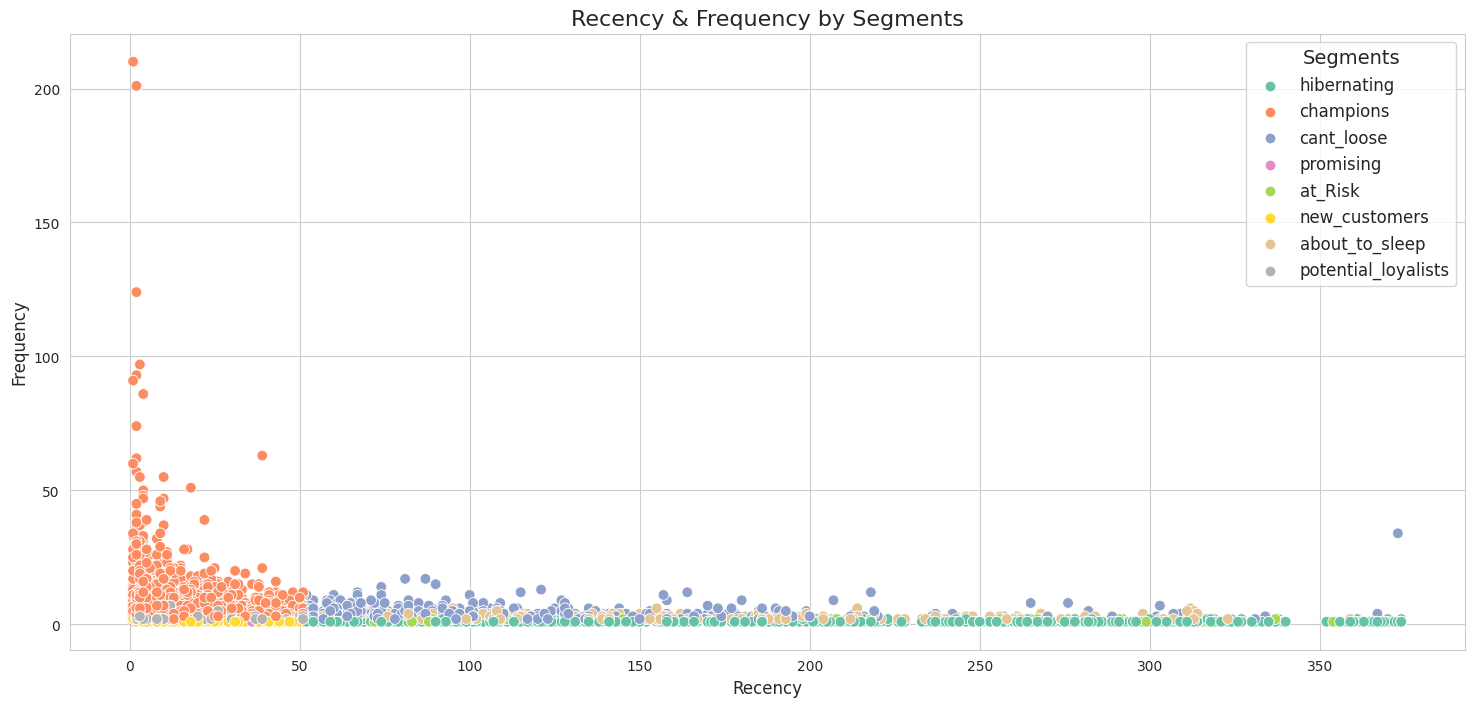

In [25]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="frequency", hue="segment", palette=palette, s=60
)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

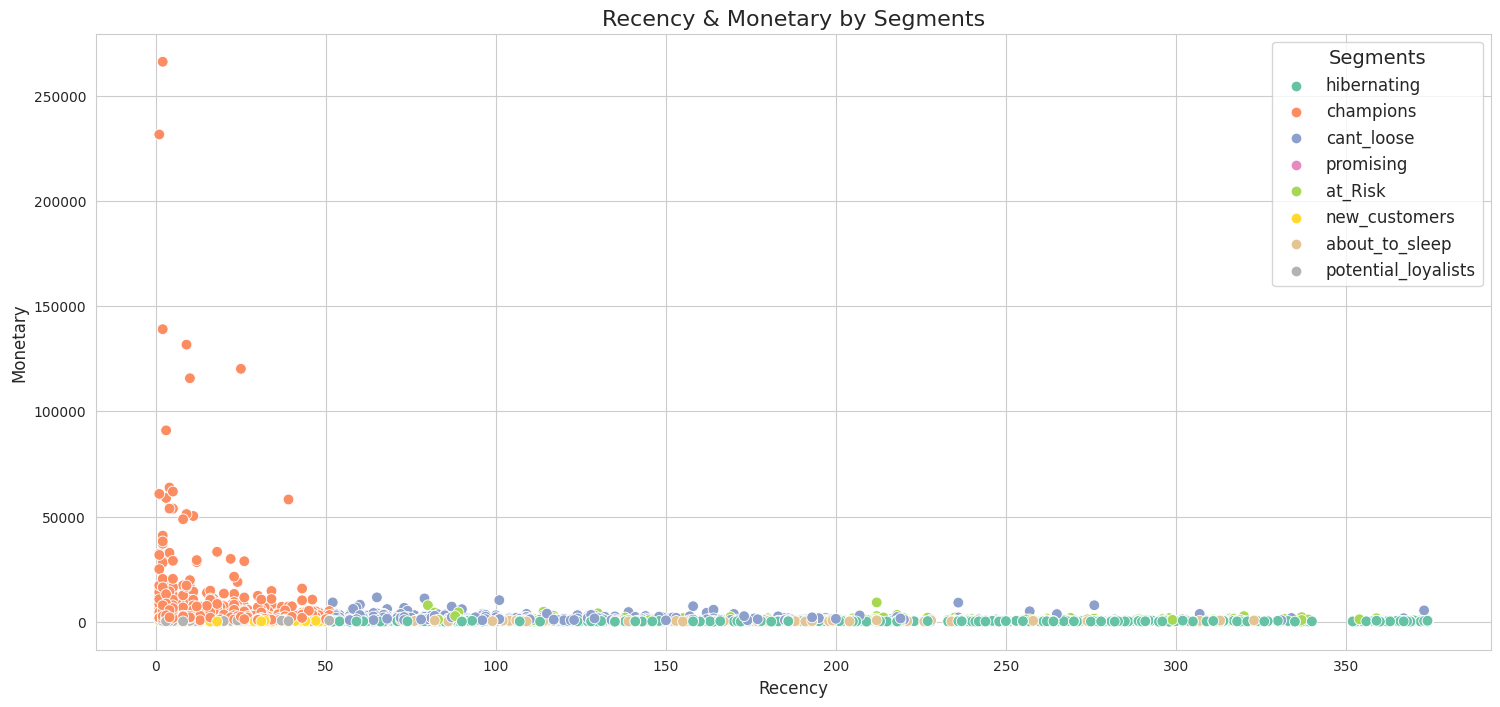

In [27]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="monetary", hue="segment", palette=palette, s=60
)
plt.title("Recency & Monetary by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Monetary", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

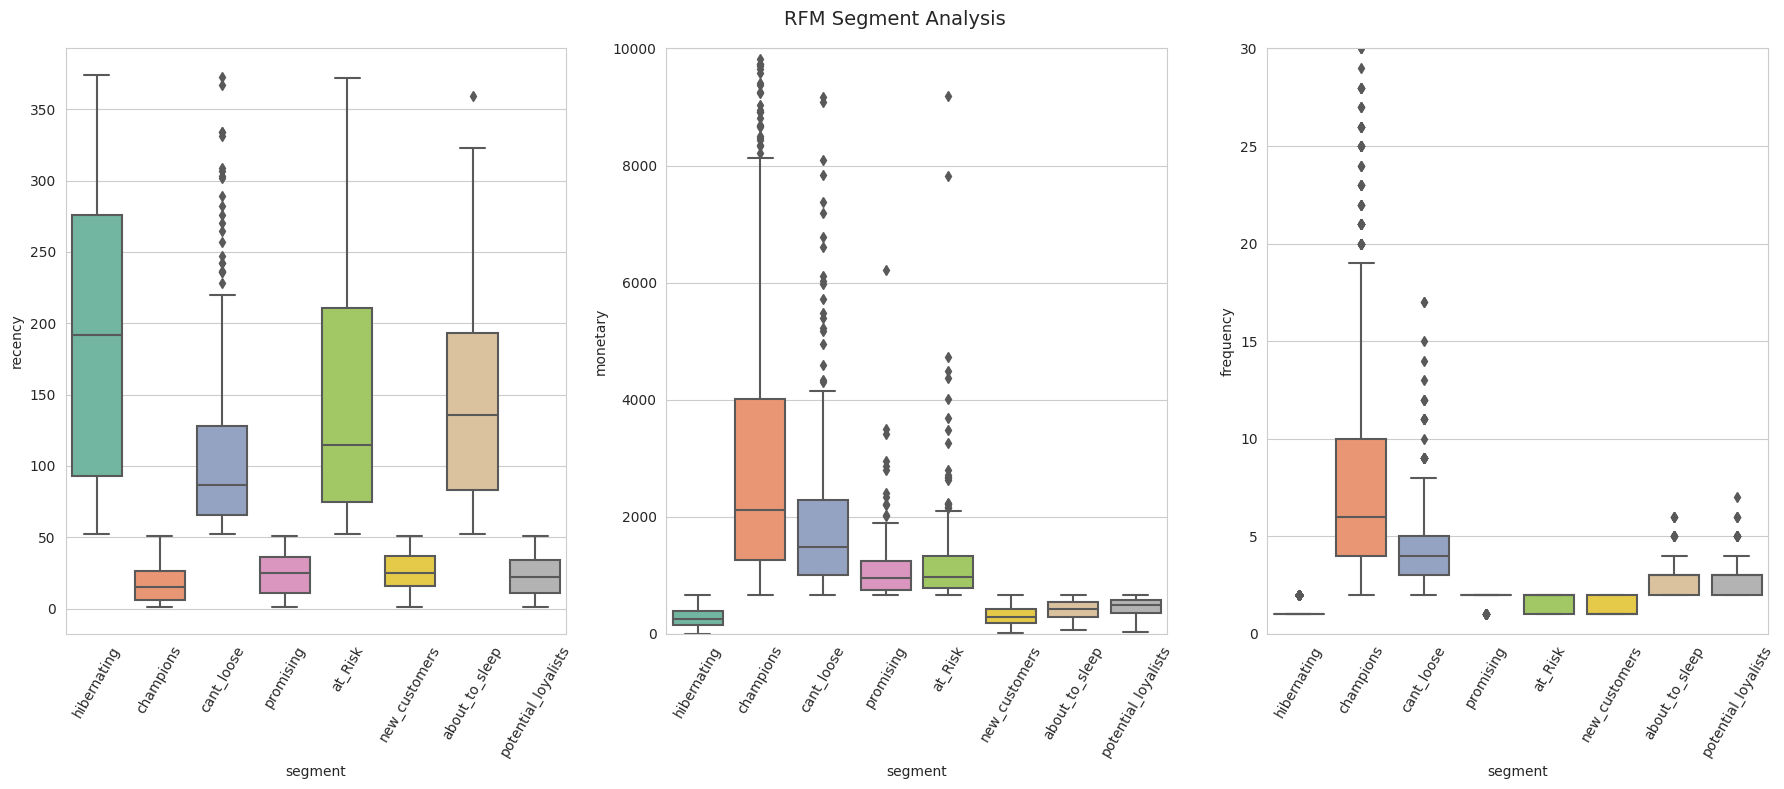

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("RFM Segment Analysis", size=14)
feature_list = ["recency", "monetary", "frequency"]
for idx, col in enumerate(feature_list):
    sns.boxplot(
        ax=axes[idx], data=rfm, x="segment", y=feature_list[idx], palette=palette
    )
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    if idx == 1:
        axes[idx].set_ylim([0, 10000])
    if idx == 2:
        axes[idx].set_ylim([0, 30])
plt.tight_layout()
plt.show()

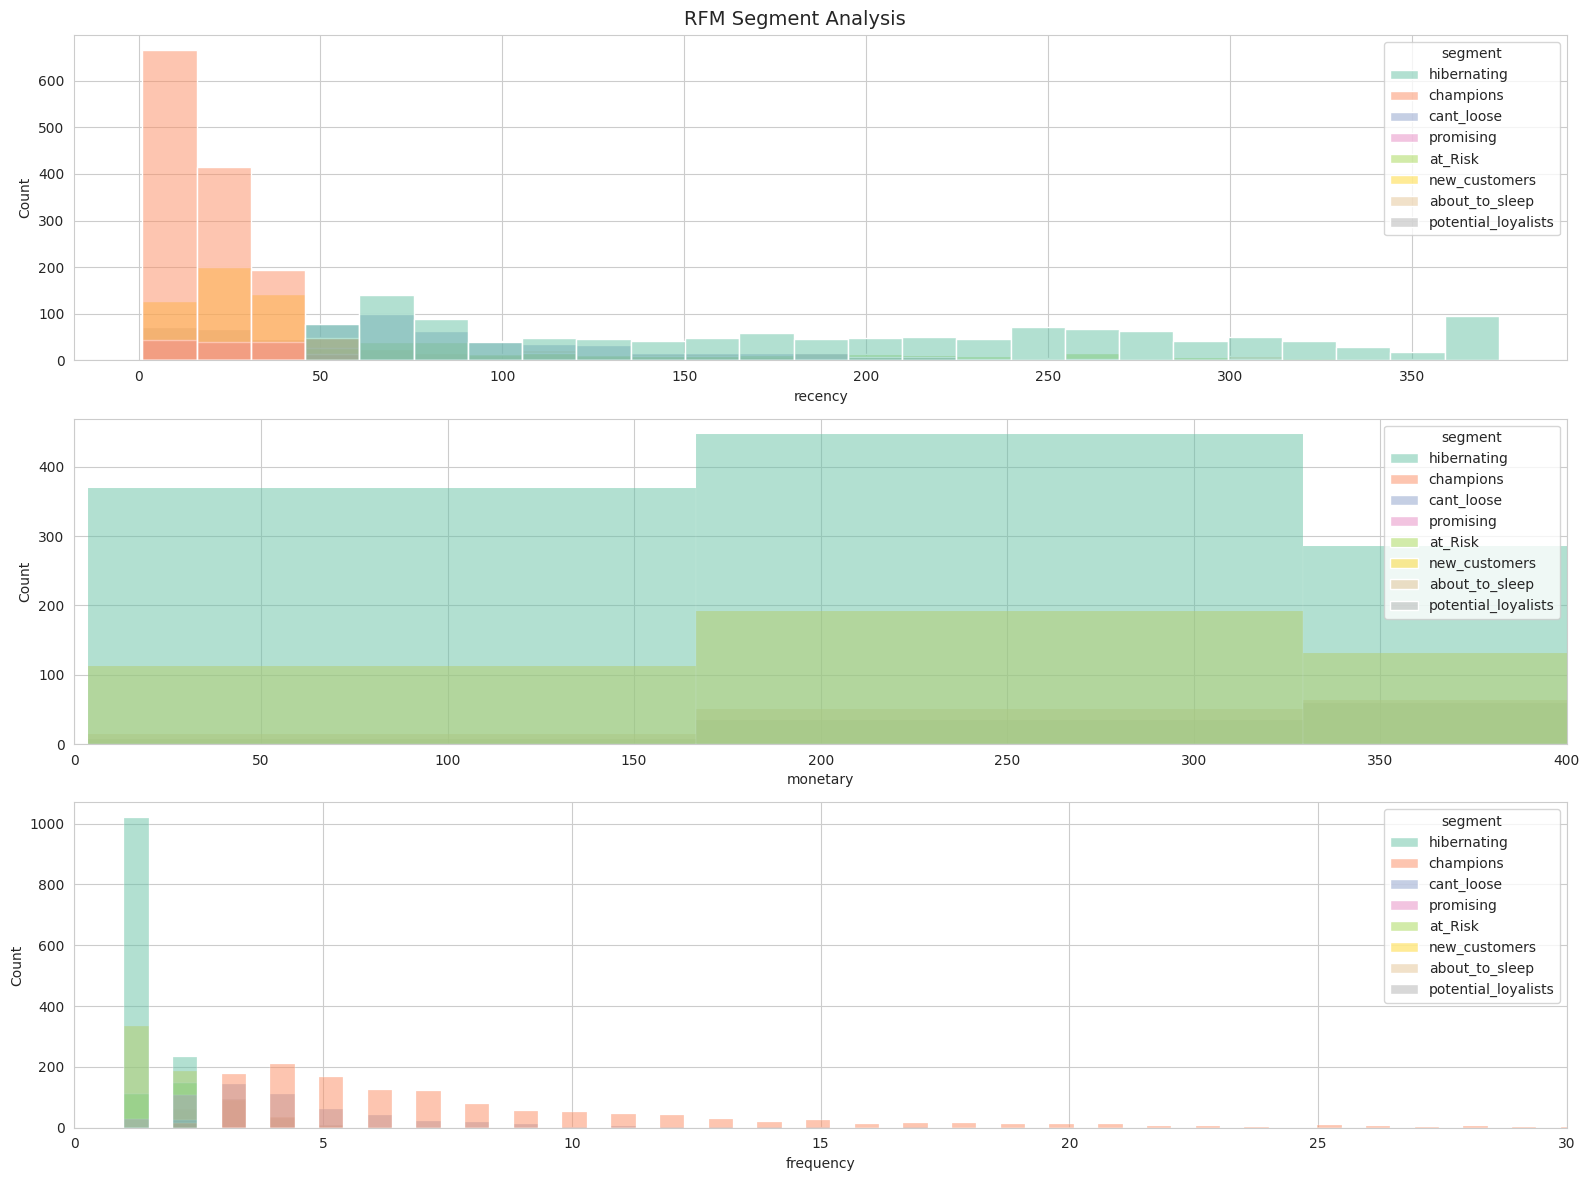

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['recency', 'monetary', 'frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                 hue = 'segment', x = feature_list[idx],
                 palette= palette)
    if idx == 1:
        axes[idx].set_xlim([0, 400])
    if idx == 2:
        axes[idx].set_xlim([0, 30])
plt.tight_layout()
plt.show()

## Cohort Analysis

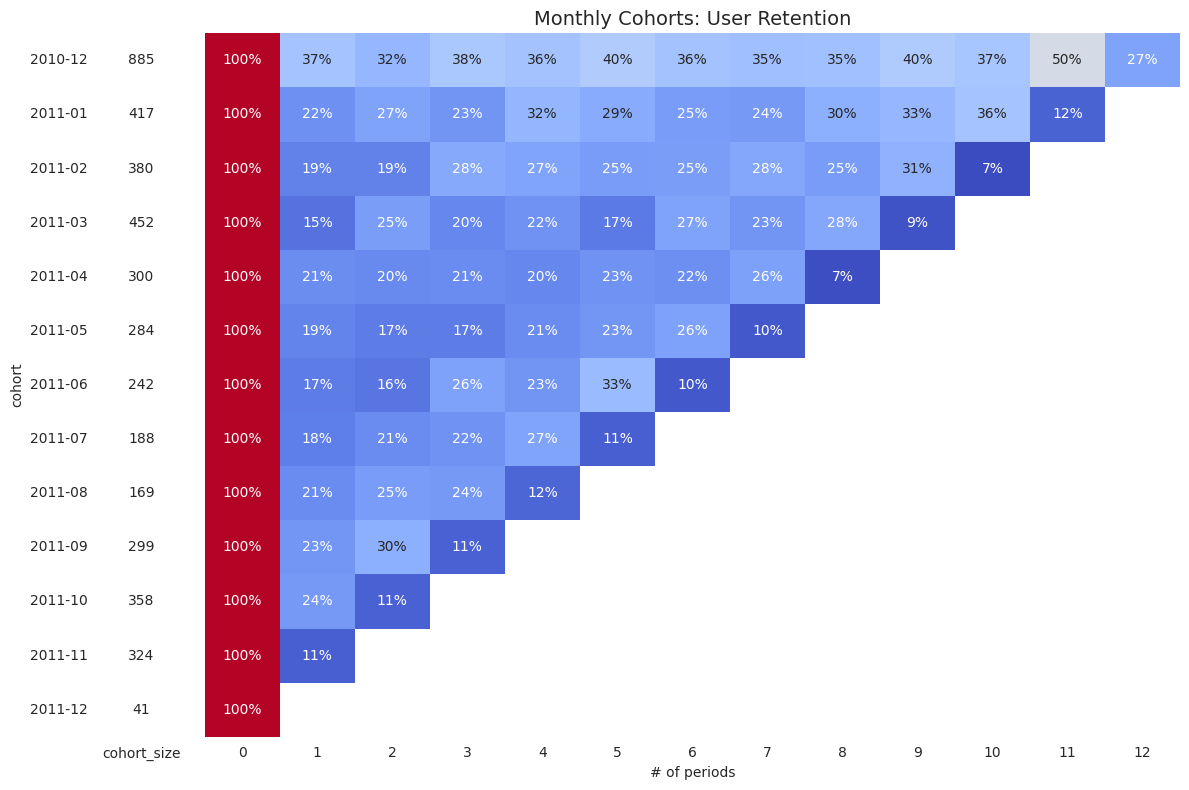

In [35]:
def CohortAnalysis(dataframe):

    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(df)

## Customer Lifetime Value

In [37]:
cltv_df = df.groupby("CustomerID").agg(
    {
        "InvoiceDate": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (today_date - x.min()).days,
        ],
        "InvoiceNo": "nunique",
        "TotalPrice": "sum",
    }
)

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "Tenure", "frequency", "monetary"]
cltv_df.head()

,recency,Tenure,frequency,monetary
CustomerID,,,,
12346,0,326,1,310.44
12347,365,368,7,4310.00
12348,282,359,4,1770.78
12349,0,19,1,1491.72
12350,0,311,1,331.46


In [39]:
#Average Order Value
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

#Recency & Tenure
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["Tenure"] = cltv_df["Tenure"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [40]:
cltv_df.head()

,recency,Tenure,frequency,monetary
CustomerID,,,,
12347,7.448980,52.571429,7,87.959184
12348,5.755102,51.285714,4,110.673750
12352,5.306122,42.428571,8,27.442813
12356,6.163265,46.571429,3,312.381111
12358,3.040816,21.571429,2,287.605000


## Beta Geometric Distribution

In [50]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

BGF.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["Tenure"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 1.99, alpha: 1.57, b: 6.18, r: 2.50>

In [51]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, cltv_df["frequency"], cltv_df["recency"], cltv_df["Tenure"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,16000,1.116237
1,13521,0.199157
2,17772,0.167528
3,16479,0.167528
4,13596,0.155490
5,14893,0.149821
6,14126,0.139199
7,17852,0.135321
8,17232,0.127141
9,15060,0.115256


In [53]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    4, cltv_df["frequency"], cltv_df["recency"], cltv_df["Tenure"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,16000,2.707611
1,13521,0.548301
2,16479,0.471074
3,17772,0.471074
4,13596,0.446554
5,14893,0.425897
6,17852,0.384677
7,14126,0.383231
8,17232,0.372023
9,15060,0.308083


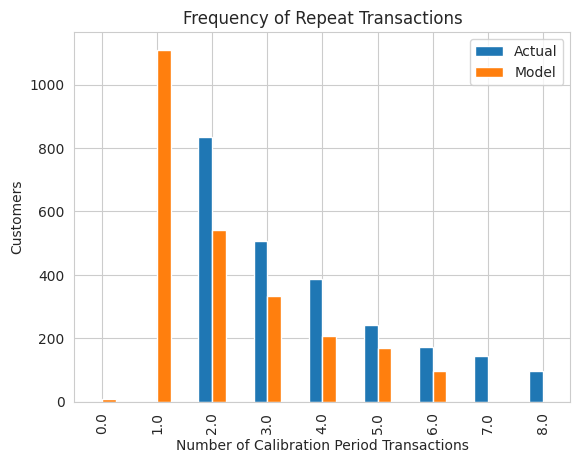

In [54]:
# Plot a figure with period actual and predicted transactions.
plot_period_transactions(BGF, max_frequency=7)
plt.show()